In [1]:
import numpy as np
import pandas as pd
import math as m
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
# from scipy import *
import scipy.linalg
from scipy.optimize import minimize
from scipy.linalg import eig, eigh
from scipy.fft import fft

from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import kneighbors_graph, NearestNeighbors
from sklearn.decomposition import KernelPCA, PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors

#import scaleogram as scg
import matplotlib.pyplot as plt
import warnings

from visuals import *
from my_lib import *
from SSA_lib import SSA

In [2]:
warnings.simplefilter('ignore')

# plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

In [3]:
def CartesianToSpherical(point):
    r = np.sqrt(sum(point ** 2))
    n = len(point)
    phi = np.zeros(n - 1)
    
    for i in range(n - 2):
        phi[i] = np.arccos(point[i] / np.sqrt(sum(point[i:] ** 2)))
        
    if point[-1] >= 0:
        phi[n - 2] = np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
    else:
        phi[n - 2] = 2 * np.pi - np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
        
    return np.hstack((phi, r))


def TrajectoryToSpherical(tr):
    tr_spherical = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_spherical[i] = CartesianToSpherical(point)
    return tr_spherical


def SphericalToCartesian(point):
    phi, r = point[:-1], point[-1]
    n = len(point)
    x = np.zeros(n) 
    cur = r
    
    for i in range(n - 1):
        x[i] = cur * np.cos(phi[i])
        cur *= np.sin(phi[i])

    x[n - 1] = cur
    return x
    

def TrajectoryToCartesian(tr):
    tr_cartesian = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_cartesian[i] = SphericalToCartesian(point)
    return tr_cartesian

In [32]:
dt = 450 * 10
data = pd.read_csv('data/long_walk_100_acc.csv', delimiter =';', decimal=',')[7007-470*2:7007+dt]

frequency = len(data)/(data['time'].values[-1]-data['time'].values[0])

assert 490 < frequency < 510, f'Bad frequency {frequency}'
print(f'Frequency {frequency}')

x_acc = ( (data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
_m = np.mean(x_acc)
_std = (sum((x_acc - _m)**2)/len(x_acc))**.5

x_acc = (x_acc-_m)

t = (data['time'].values).astype(float).reshape([-1,])
t = np.linspace(0,t[-1]-t[0],len(x_acc))

fig = go.Figure()
fig.add_scatter(y = x_acc, mode='lines', name='Sum squares')
fig.show()

Frequency 500.15629884338847


In [33]:
Fs = 500

N = len(x_acc)

__Abs = 2.0/N * np.abs(fft(x_acc)[0:N//2])

__FS = np.linspace(0.0, 1.0/2.0*Fs, N//2)

# plotting the spectrum
fig = go.Figure()
fig.add_scatter(x = __FS[0:60],
                y = __Abs[0:60],
                mode='lines',
                name='Magnitude'
               )

temp_fft = fft(x_acc)[0:N//2]

__Ph = np.arctan2(np.imag(temp_fft),np.real(temp_fft))

fig.add_scatter(x = __FS[0:60],
                y = __Ph[0:60],
                mode='markers',
                name='Phase'
               )

fig.add_trace(go.Bar(x= __FS[0:60],
                     y= __Ph[0:60],
                        #mode='markers',
                        name='Phase'
                    )
             )


fig['layout']['yaxis1'].update(title='Magnitude')
fig['layout']['xaxis1'].update(title='Frec[1/s]')
fig.show()

In [76]:
abs_del = __Abs[:27]
frq_del = __FS[:27]
phs_del = __Ph[:27]

In [77]:
x = abs_del[0]*np.cos(2*np.pi*frq_del[0]*(t - phs_del[0]))

for i in range(1,len(abs_del)):
    x += abs_del[i]*np.cos(2*np.pi*frq_del[i]*(t - phs_del[i]))

In [78]:
fig = go.Figure()
fig.add_scatter(y = x_acc, mode='lines', name='Sum squares')
fig.add_scatter(y = x_acc - x, mode='lines', name='New')
fig.add_scatter(y = x, mode='lines', name='x')
fig.show()

In [79]:
def HankelMatrix(X, L):  
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

In [80]:
X = HankelMatrix(x_acc - x,750)

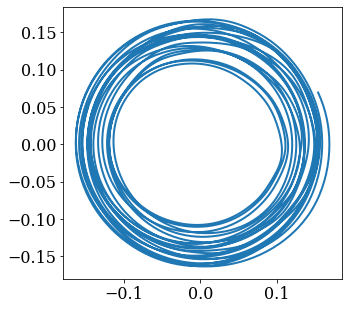

In [81]:
pca = PCA(n_components=2)
X_PCA = pca.fit_transform(X)
X_PCA = X_PCA/X_PCA.std(axis=0)/10
plt.plot(X_PCA[:,0],X_PCA[:,1]);

In [82]:
def Trigonometric_series(w):
    
    w = w.reshape((int(len(w)/2),2))*20
    
    phi = np.linspace(0,2*np.pi,1000)
    
    x_ph = np.zeros(1000)+0j

    for k in range(len(x_ph)):    
        ans = 0 
        for i in range(len(w)):
            ans += w[i,0]*np.sin(i*phi[k]) + w[i,1]*np.cos(i*phi[k])*1j
        x_ph[k] = ans
        
    x_ph = x_ph.reshape((len(x_ph),1))

    x_ph = np.concatenate((np.real(x_ph), np.imag(x_ph)), axis=1)
    
    return x_ph

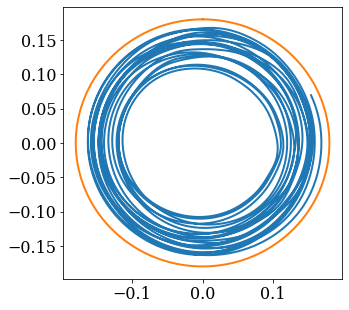

In [83]:
plt.plot(X_PCA[:,0],X_PCA[:,1])
x_tr = Trigonometric_series(np.array([0.,0.,.009,.009,0.,0.]))
plt.plot(x_tr[:,0],x_tr[:,1])
plt.show()

In [84]:
def Loss(w):
    x_ph = Trigonometric_series(w)
    nn = NearestNeighbors(n_neighbors = 12, p = 2).fit(X_PCA)
    dists, idxs = nn.kneighbors(x_ph)
    return np.sum(dists)

def Loss_sp(w):
    x_ph = Trigonometric_series(w)
    x_ph_sph = TrajectoryToSpherical(x_ph)
    nn = NearestNeighbors(n_neighbors = 12,p = 1).fit(X_PCA_sph)
    dists, idxs = nn.kneighbors(x_ph_sph)
    return np.sum(dists)

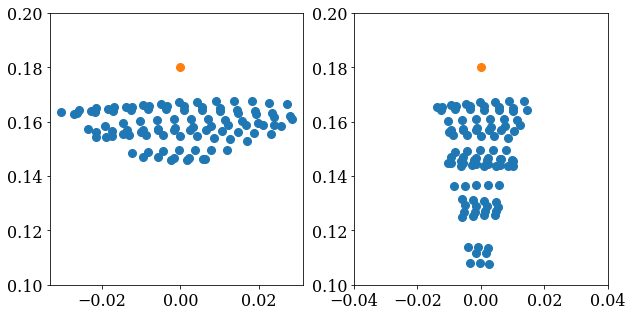

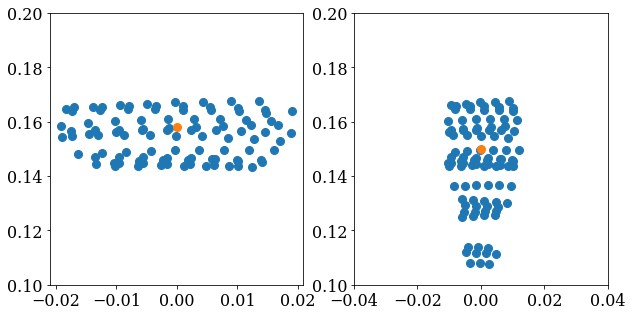

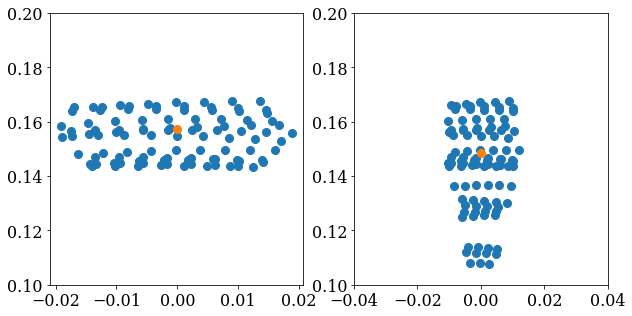

Optimization terminated successfully.
         Current function value: 152.660105
         Iterations: 149
         Function evaluations: 250


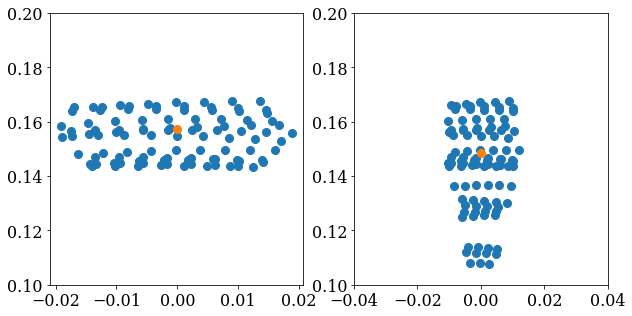

Optimization terminated successfully.
         Current function value: 152.660105
         Iterations: 149
         Function evaluations: 250


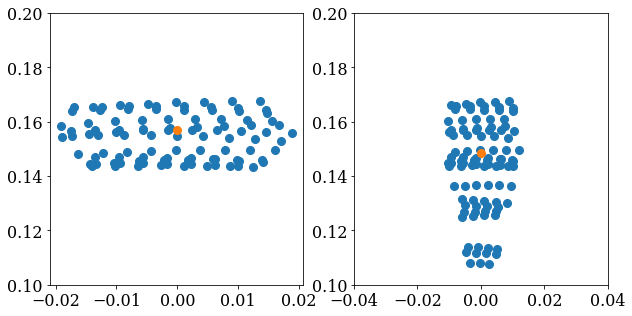

In [85]:
w0 = np.array([0.,0.,.009,.009,0.,0.])

pca = PCA(n_components=2)
X_PCA = pca.fit_transform(X)
X_PCA = X_PCA/X_PCA.std(axis=0)/10

X_PCA_sph = TrajectoryToSpherical(X_PCA)

for _iter in range(1,250,50):
    fig, axs = plt.subplots(1, 2, figsize = (10,5))
    
    
    res = minimize(Loss, w0,
                   method='nelder-mead',
                   options={'xtol': 1e-3, 'disp': True, 'maxiter': _iter})
    
    x_tr = Trigonometric_series(res.x)

    nn = NearestNeighbors(n_neighbors = 100, p = 2).fit(X_PCA)
    dists, idxs = nn.kneighbors(x_tr)
    
    axs[0].plot(X_PCA[idxs[0],0],X_PCA[idxs[0],1],'o')
    axs[0].plot(x_tr[0,0],x_tr[0,1],'o')
    axs[0].set_ylim(0.1,0.2)
    
    ####################################################################################################
    res_pf = minimize(Loss_sp, w0,
                       method='nelder-mead',
                       options={'xtol': 1e-3, 'disp': True, 'maxiter': _iter})
    
    x_tr = Trigonometric_series(res_pf.x)
    x_tr_sp = TrajectoryToSpherical(x_tr)

    nn = NearestNeighbors(n_neighbors = 100, p = 1).fit(X_PCA_sph)
    dists, idxs = nn.kneighbors(x_tr_sp)
    
    axs[1].plot(X_PCA[idxs[0],0],X_PCA[idxs[0],1],'o')
    axs[1].plot(x_tr[0,0],x_tr[0,1],'o')
    axs[1].set_xlim(-0.04,0.04)
    axs[1].set_ylim(0.1,0.2)
    
    plt.show()

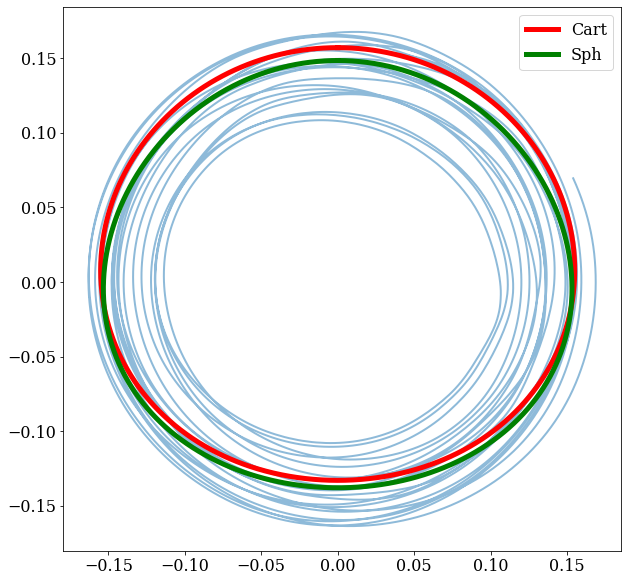

In [86]:
plt.figure(figsize=(10,10))
plt.plot(X_PCA[:,0],X_PCA[:,1],alpha = 0.5)

x_tr = Trigonometric_series(res.x)
plt.plot(x_tr[:,0],x_tr[:,1],'r',label = 'Cart',linewidth = 5)

x_tr = Trigonometric_series(res_pf.x)
plt.plot(x_tr[:,0],x_tr[:,1],'g',label = 'Sph',linewidth = 5)

plt.legend()
plt.show()

In [87]:
fig = go.Figure()

fig.update_layout( autosize=False, width=800, height=800)

fig.add_scatter(x = X_PCA[:,0],y = X_PCA[:,1], mode='lines', name='X_PCA',opacity=0.5)

x_tr = Trigonometric_series(res.x)
fig.add_scatter(x = x_tr[:,0],y = x_tr[:,1], mode='lines', name='Cart')

x_tr = Trigonometric_series(res_pf.x)
fig.add_scatter(x = x_tr[:,0],y = x_tr[:,1], mode='lines', name='Sph')

fig.show()

In [90]:
pca_ = PCA(n_components=3)
X_PCA_d = pca_.fit_transform(X)

In [91]:
fig_2 = go.Figure()
fig_2.update_layout(autosize=False, width=1000, height=1000)

fig_2.add_trace(go.Scatter3d(x=X_PCA_d[:,0],
                             y=X_PCA_d[:,1],
                             z=X_PCA_d[:,2],
                             mode='lines'
                            )
                )


fig_2.layout.template = 'plotly_white'
fig_2.show()